## Import essential libraries

In [26]:
from google.genai import types
import os
from google import genai
api_key = os.environ.get("GEMINI_API_KEY")
if not api_key:
    raise ValueError("Please set the GEMINI_API_KEY environment variable")

client = genai.Client(api_key=api_key)

Both GOOGLE_API_KEY and GEMINI_API_KEY are set. Using GOOGLE_API_KEY.


**USECASE**: receipt understanding

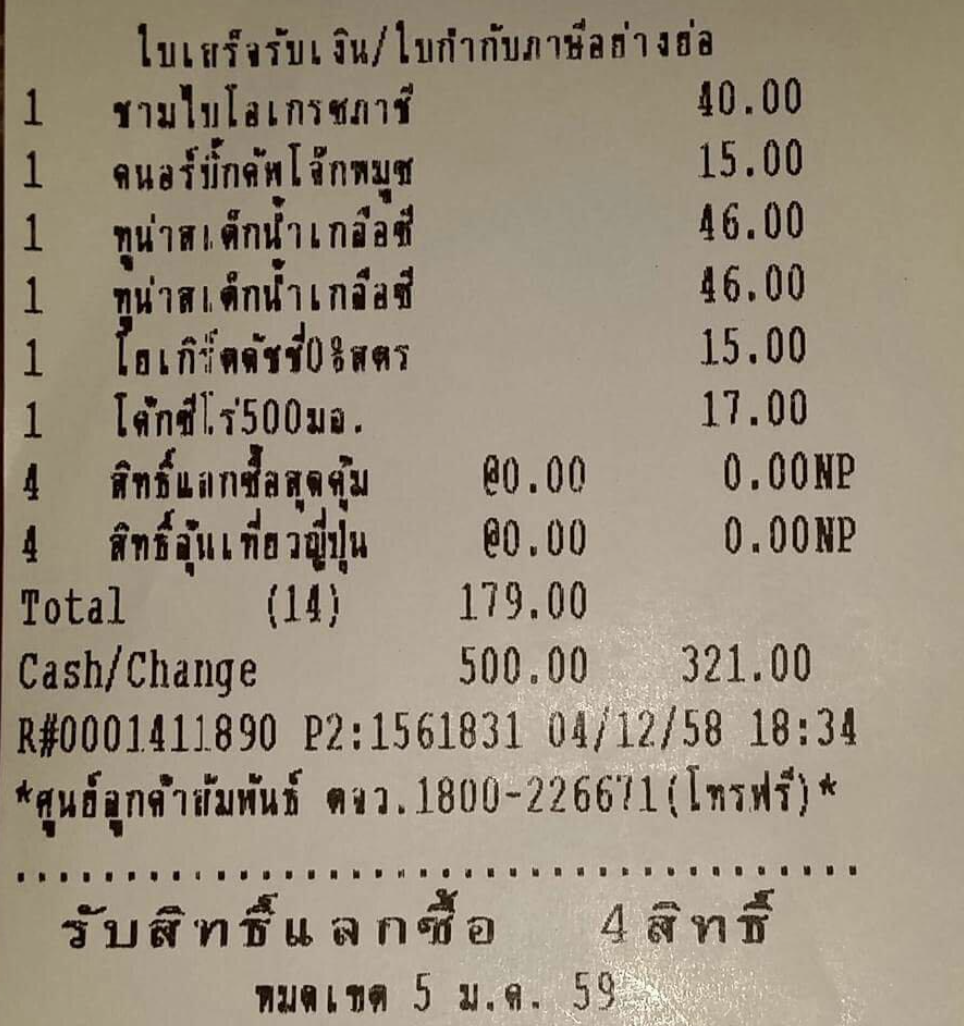

In [27]:
from IPython.display import Image, display

with open('reciept.png', 'rb') as f:
    image_bytes = f.read()

display(Image(data=image_bytes))

In [28]:
from pydantic import BaseModel

class RecieptFormat(BaseModel):
    item: str
    amount: str

response = client.models.generate_content(
model='gemini-2.5-flash',
contents=[
    types.Part.from_bytes(
    data=image_bytes,
    mime_type='image/jpeg',
    ),
    'Please extract each item in the reciept and its amount and provide it in a structured format.'
],
config={
    'response_mime_type': 'application/json',
    'response_schema': list[RecieptFormat],
},
)

print(response.text)

[
  {
    "item": "ชามไบโอเกรซชี",
    "amount": "40.00"
  },
  {
    "item": "คนอร์ซุปกั๊ตโฉมพูช",
    "amount": "15.00"
  },
  {
    "item": "ทูน่าสเต๊กน้ำเกลือชิ",
    "amount": "46.00"
  },
  {
    "item": "ทูน่าสเต๊กน้ำเกลือชิ",
    "amount": "46.00"
  },
  {
    "item": "โยเกิร์ตดัชชี่0%รส",
    "amount": "15.00"
  },
  {
    "item": "โค้กซีโร่500มล.",
    "amount": "17.00"
  },
  {
    "item": "สิทธิ์แลกซื้อสุดคุ้ม",
    "amount": "0.00"
  },
  {
    "item": "สิทธิ์ลุ้นเที่ยวญี่ปุ่น",
    "amount": "0.00"
  }
]


Question & Answering about images or captioning

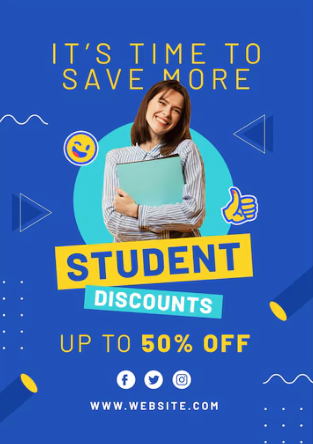

In [29]:
from IPython.display import Image, display

with open('poster.png', 'rb') as f:
    image_bytes = f.read()

display(Image(data=image_bytes))

In [30]:
response = client.models.generate_content(
model='gemini-2.5-flash',
contents=[
    types.Part.from_bytes(
    data=image_bytes,
    mime_type='image/jpeg',
    ),
    # 'What is the discount percentage on the poster?',
    'Please provide a concise caption the image. Do not make assumptions about the image.',
],
)

print(response.text)

A blue and yellow poster advertising "Student Discounts" up to 50% off, featuring a smiling woman, social media icons, and a website address.


**Usecase - Object detection**. Note: For production a smaller model fit to purpose like YOLO is recommended over LLM to perform object detection. Due to Latency.

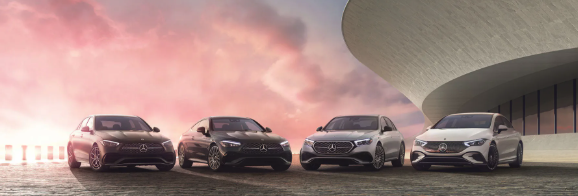

In [31]:
from IPython.display import Image, display

with open('cars.png', 'rb') as f:
    image_bytes = f.read()

display(Image(data=image_bytes))

In [32]:
from pydantic import BaseModel
from typing import List
import cv2
import numpy as np
import json
import google.genai as genai
from google.genai import types

class BoundingBox(BaseModel):
    x: float  # x-coordinate of top-left corner (normalized 0-1)
    y: float  # y-coordinate of top-left corner (normalized 0-1)
    width: float  # width of bounding box (normalized 0-1)
    height: float  # height of bounding box (normalized 0-1)
    confidence: float  # confidence score (0-1)

class CarDetection(BaseModel):
    object_class: str  # should be "car"
    bounding_box: BoundingBox

# Create the schema manually for Google GenAI
detection_schema = types.Schema(
    type=types.Type.ARRAY,
    items=types.Schema(
        type=types.Type.OBJECT,
        properties={
            "object_class": types.Schema(type=types.Type.STRING),
            "bounding_box": types.Schema(
                type=types.Type.OBJECT,
                properties={
                    "x": types.Schema(type=types.Type.NUMBER),
                    "y": types.Schema(type=types.Type.NUMBER),
                    "width": types.Schema(type=types.Type.NUMBER),
                    "height": types.Schema(type=types.Type.NUMBER),
                    "confidence": types.Schema(type=types.Type.NUMBER),
                },
                required=["x", "y", "width", "height", "confidence"]
            )
        },
        required=["object_class", "bounding_box"]
    )
)

# Detection
response = client.models.generate_content(
    model='gemini-2.5-flash',
    contents=[
        types.Part.from_bytes(
            data=image_bytes,
            mime_type='image/jpeg',
        ),
        '''Detect all cars in this image and provide bounding box coordinates for each car. 
        For each detected car, provide:
        - Normalized coordinates (0-1) where (0,0) is top-left corner
        - x, y: top-left corner of bounding box
        - width, height: dimensions of bounding box
        - confidence: your confidence in the detection (0-1)
        
        Only detect objects that are clearly cars (sedans, SUVs, trucks, etc.).'''
    ],
    config=types.GenerateContentConfig(
        response_mime_type='application/json',
        response_schema=detection_schema,
    ),
)

# Parse results
detections = json.loads(response.text)
car_detections = [CarDetection(**detection) for detection in detections]

def draw_detections(image_bytes, detections, output_path="detected_cars.jpg"):
    """
    Draw bounding boxes using cv2 - lean version
    """
    # Convert bytes to numpy array
    nparr = np.frombuffer(image_bytes, np.uint8)
    image = cv2.imdecode(nparr, cv2.IMREAD_COLOR)
    
    if image is None:
        raise ValueError("Could not decode image from bytes")
    
    height, width = image.shape[:2]
    
    # Colors for different detections (BGR format for cv2)
    colors = [(0, 255, 0), (255, 0, 0), (0, 0, 255), (255, 255, 0), (255, 0, 255)]
    
    for i, detection in enumerate(detections):
        bbox = detection.bounding_box
        color = colors[i % len(colors)]
        
        # Convert normalized coordinates to pixels
        x1 = int(bbox.x * width)
        y1 = int(bbox.y * height)
        x2 = int((bbox.x + bbox.width) * width)
        y2 = int((bbox.y + bbox.height) * height)
        
        # Draw bounding box
        cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)
        
        # Prepare label
        label = f"{detection.object_class}: {bbox.confidence:.2f}"
        
        # Get text size for background
        (text_width, text_height), baseline = cv2.getTextSize(
            label, cv2.FONT_HERSHEY_SIMPLEX, 0.6, 2
        )
        
        # Draw label background
        cv2.rectangle(
            image, 
            (x1, y1 - text_height - 10), 
            (x1 + text_width, y1), 
            color, -1
        )
        
        # Draw label text
        cv2.putText(
            image, label, (x1, y1 - 5),
            cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2
        )
    
    # Save result
    cv2.imwrite(output_path, image)
    print(f"Saved annotated image: {output_path}")
    return image

# Usage
print(f"Found {len(car_detections)} cars:")
for i, detection in enumerate(car_detections):
    bbox = detection.bounding_box
    print(f"Car {i+1}: {bbox.confidence:.2f} confidence at ({bbox.x:.3f}, {bbox.y:.3f})")

# Draw and save
if car_detections:
    annotated_image = draw_detections(image_bytes, car_detections)
    print("✅ Image with bounding boxes saved!")
else:
    print("No cars detected")

# Optional: Display in window (remove if running headless)
# cv2.imshow("Car Detection", annotated_image)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

Found 4 cars:
Car 1: 0.95 confidence at (0.000, 0.444)
Car 2: 0.95 confidence at (0.231, 0.449)
Car 3: 0.95 confidence at (0.469, 0.441)
Car 4: 0.95 confidence at (0.686, 0.441)
Saved annotated image: detected_cars.jpg
✅ Image with bounding boxes saved!
